# TFM: Algoritmos de Machine Learning para la modelización de la caída de cartera en el sector asegurador. 
## Domingo Martínez Pérez

## Carga del conjunto de datos

In [2]:
import pandas as pd

df = pd.read_csv('autoinsurance_churn.csv')

print(df.head())

   individual_id    address_id  curr_ann_amt  days_tenure cust_orig_date  \
0   2.213000e+11  5.213000e+11    818.877997       1454.0     2018-12-09   
1   2.213001e+11  5.213001e+11    974.199182       1795.0     2018-01-02   
2   2.213007e+11  5.213002e+11    967.375112       4818.0     2009-09-23   
3   2.213016e+11  5.213006e+11    992.409561        130.0     2022-07-25   
4   2.213016e+11  5.213006e+11    784.633494       5896.0     2006-10-11   

   age_in_years date_of_birth   latitude  longitude           city  ...  \
0            44    1978-06-23  32.578829 -96.305006        Kaufman  ...   
1            72    1950-05-30  32.732209 -97.000893  Grand Prairie  ...   
2            55    1967-07-07  32.819777 -96.846938         Dallas  ...   
3            53    1969-05-25  32.684065 -97.162180      Arlington  ...   
4            50    1972-09-25  32.751398 -97.376745     Fort Worth  ...   

     income has_children  length_of_residence  marital_status  \
0   22500.0          1.0   

## Comprensión y preparación de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   individual_id        1048575 non-null  float64
 1   address_id           1048575 non-null  float64
 2   curr_ann_amt         1048575 non-null  float64
 3   days_tenure          1048575 non-null  float64
 4   cust_orig_date       1048575 non-null  object 
 5   age_in_years         1048575 non-null  int64  
 6   date_of_birth        1048575 non-null  object 
 7   latitude             890412 non-null   float64
 8   longitude            890412 non-null   float64
 9   city                 1041065 non-null  object 
 10  state                1048575 non-null  object 
 11  county               1041065 non-null  object 
 12  income               1048575 non-null  float64
 13  has_children         1048575 non-null  float64
 14  length_of_residence  1048575 non-null  float64
 15

In [4]:
df.isnull().sum()

individual_id               0
address_id                  0
curr_ann_amt                0
days_tenure                 0
cust_orig_date              0
age_in_years                0
date_of_birth               0
latitude               158163
longitude              158163
city                     7510
state                       0
county                   7510
income                      0
has_children                0
length_of_residence         0
marital_status              0
home_market_value       57429
home_owner                  0
college_degree              0
good_credit                 0
acct_suspd_date        927686
Churn                       0
dtype: int64

### Eliminaremos varios atributos que nos dan información redundante e innecesaria para la predicción del churn.


In [5]:
# Lista de columnas a eliminar
cols_to_drop = ['individual_id', 'address_id', 'cust_orig_date', 'date_of_birth', 'acct_suspd_date', 'latitude', 'longitude']

df = df.drop(columns=cols_to_drop)

print(df.columns)

Index(['curr_ann_amt', 'days_tenure', 'age_in_years', 'city', 'state',
       'county', 'income', 'has_children', 'length_of_residence',
       'marital_status', 'home_market_value', 'home_owner', 'college_degree',
       'good_credit', 'Churn'],
      dtype='object')


In [6]:
cat_cols = df.select_dtypes(include='object').columns
print(cat_cols)

Index(['city', 'state', 'county', 'marital_status', 'home_market_value'], dtype='object')


In [7]:
for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False))


--- city ---
city
Dallas                   190591
Fort Worth               136830
Arlington                 61551
Plano                     52529
Garland                   38635
                          ...  
Era                         109
Forreston                    83
Chatfield                    61
Mertens                      40
Naval Air Station Jrb        32
Name: count, Length: 96, dtype: int64

--- state ---
state
TX    1048575
Name: count, dtype: int64

--- county ---
county
Dallas      388939
Tarrant     303419
Collin      137086
Denton      116870
Ellis        27365
Kaufman      19814
Parker       15219
Johnson      14835
Rockwall     14803
NaN           7510
Hunt          1059
Cooke          982
Navarro        370
Grayson        264
Hill            40
Name: count, dtype: int64

--- marital_status ---
marital_status
Married    653610
Single     394965
Name: count, dtype: int64

--- home_market_value ---
home_market_value
75000 - 99999      191137
100000 - 124999    17328

### Vamos a eliminar el atributo state al contener solo un valor (TEXAS)

In [8]:
df = df.drop(columns=['state'])

print(df.columns)

Index(['curr_ann_amt', 'days_tenure', 'age_in_years', 'city', 'county',
       'income', 'has_children', 'length_of_residence', 'marital_status',
       'home_market_value', 'home_owner', 'college_degree', 'good_credit',
       'Churn'],
      dtype='object')


### Ahora vamos a codificar la variable marital_status, ya que solo contiene 2 valores. Con el objetivo de optimizar nuestro conjunto de datos los valores married serán un 1, y los valores single serán un 0.

In [9]:
df['marital_status'] = df['marital_status'].astype(str)

In [10]:
df['marital_status'] = df['marital_status'].map({'Married': 1, 'Single': 0})

### Ahora vamos a renombrar los valores de la variable home_market_value para poder trabajar con datos numéricos y no con un rango que será difícil de manejar.

In [11]:
import pandas as pd

# Función para calcular el valor medio del rango
def calcular_media(rango):
    # Verificar si el valor es NaN
    if pd.isna(rango):  
        return None  
    elif 'Plus' in str(rango):  # Convertimos a string antes de buscar 'Plus'
        return 1000000  
    else:
        # Extraemos los valores del rango
        limites = rango.split(' - ')
        # Calculamos la media entre los dos valores
        return (int(limites[0]) + int(limites[1])) / 2


In [12]:
# Aplicar la función de calcular la media a la columna 'home_market_value'
df['home_market_value'] = df['home_market_value'].apply(calcular_media)

print(df[['home_market_value']])

         home_market_value
0                  62499.5
1                  62499.5
2                  87499.5
3                 187499.5
4                 237499.5
...                    ...
1048570            62499.5
1048571                NaN
1048572           137499.5
1048573           162499.5
1048574           137499.5

[1048575 rows x 1 columns]


In [13]:
print(df)

         curr_ann_amt  days_tenure  age_in_years           city   county  \
0          818.877997       1454.0            44        Kaufman  Kaufman   
1          974.199182       1795.0            72  Grand Prairie   Dallas   
2          967.375112       4818.0            55         Dallas   Dallas   
3          992.409561        130.0            53      Arlington  Tarrant   
4          784.633494       5896.0            50     Fort Worth  Tarrant   
...               ...          ...           ...            ...      ...   
1048570   1241.328992       5902.0            39       Mesquite   Dallas   
1048571    804.546760       6022.0            55        Garland   Dallas   
1048572    781.851209       3474.0            35         Dallas   Dallas   
1048573    697.935600         95.0            44         Irving   Dallas   
1048574    997.155842       4772.0            47          Allen   Collin   

             income  has_children  length_of_residence  marital_status  \
0         225

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   curr_ann_amt         1048575 non-null  float64
 1   days_tenure          1048575 non-null  float64
 2   age_in_years         1048575 non-null  int64  
 3   city                 1041065 non-null  object 
 4   county               1041065 non-null  object 
 5   income               1048575 non-null  float64
 6   has_children         1048575 non-null  float64
 7   length_of_residence  1048575 non-null  float64
 8   marital_status       1048575 non-null  int64  
 9   home_market_value    991146 non-null   float64
 10  home_owner           1048575 non-null  float64
 11  college_degree       1048575 non-null  float64
 12  good_credit          1048575 non-null  float64
 13  Churn                1048575 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 1

### Vamos a observar la cantidad de valores con decimal diferente a 0 en la variable days_tenure, ya que el dato podría ser tratado como un entero.

In [15]:
# Verificar si hay valores con decimales diferentes a .0
non_zero_decimal_values = df[df['days_tenure'] != df['days_tenure'].astype(int)]

# Contar cuántos registros tienen decimales diferentes a .0
num_non_zero_decimal_values = len(non_zero_decimal_values)
print(f'Cantidad de valores con decimales diferentes a .0: {num_non_zero_decimal_values}')

Cantidad de valores con decimales diferentes a .0: 0


In [16]:
# Convertir los valores a enteros truncando la parte decimal
df['days_tenure'] = df['days_tenure'].astype(int)

In [17]:
print(df.dtypes)

curr_ann_amt           float64
days_tenure              int64
age_in_years             int64
city                    object
county                  object
income                 float64
has_children           float64
length_of_residence    float64
marital_status           int64
home_market_value      float64
home_owner             float64
college_degree         float64
good_credit            float64
Churn                    int64
dtype: object


### Ahora hacemos lo mismo para la variable length_of_residence, ya que deberían ser valores enteros.

In [18]:
# Filtrar los valores que tienen un decimal diferente a .0
non_zero_single_decimal_values_residence = df[
    (df['length_of_residence'] != df['length_of_residence'].astype(int)) & 
    (df['length_of_residence'] * 10 == df['length_of_residence'].astype(int) * 10)
]

# Contar cuántos registros tienen decimales diferentes a .0
num_non_zero_single_decimal_values_residence = len(non_zero_single_decimal_values_residence)
print(f'Cantidad de valores con un decimal diferente a .0 en "length_of_residence": {num_non_zero_single_decimal_values_residence}')

# Mostrar algunos de los registros con decimales diferentes a .0
print(non_zero_single_decimal_values_residence[['length_of_residence']].head())

Cantidad de valores con un decimal diferente a .0 en "length_of_residence": 0
Empty DataFrame
Columns: [length_of_residence]
Index: []


In [19]:
# Convertir los valores a enteros truncando la parte decimal
df['length_of_residence'] = df['length_of_residence'].astype(int)

In [20]:
print(df.dtypes)

curr_ann_amt           float64
days_tenure              int64
age_in_years             int64
city                    object
county                  object
income                 float64
has_children           float64
length_of_residence      int64
marital_status           int64
home_market_value      float64
home_owner             float64
college_degree         float64
good_credit            float64
Churn                    int64
dtype: object


In [21]:
print(df)

         curr_ann_amt  days_tenure  age_in_years           city   county  \
0          818.877997         1454            44        Kaufman  Kaufman   
1          974.199182         1795            72  Grand Prairie   Dallas   
2          967.375112         4818            55         Dallas   Dallas   
3          992.409561          130            53      Arlington  Tarrant   
4          784.633494         5896            50     Fort Worth  Tarrant   
...               ...          ...           ...            ...      ...   
1048570   1241.328992         5902            39       Mesquite   Dallas   
1048571    804.546760         6022            55        Garland   Dallas   
1048572    781.851209         3474            35         Dallas   Dallas   
1048573    697.935600           95            44         Irving   Dallas   
1048574    997.155842         4772            47          Allen   Collin   

             income  has_children  length_of_residence  marital_status  \
0         225

### Pasamos a entero las columnas binarias que las tenemos como decimal.

In [22]:
binary_columns = ['has_children', 'home_owner', 'college_degree', 'good_credit', 'marital_status']
df[binary_columns] = df[binary_columns].astype(int)

### Ahora, antes de codificar las variables categoricas city y county, vamos a eliminar las muestras en las que dichas variables son nulas. Ya que son muy pocas muestras, no afectará al modelo.

In [23]:
print("Nulos en 'county':", df['county'].isna().sum())
print("Nulos en 'city':", df['city'].isna().sum())

Nulos en 'county': 7510
Nulos en 'city': 7510


In [24]:
df = df.dropna(subset=['county', 'city'])


In [25]:
print("Nulos en 'county':", df['county'].isna().sum())
print("Nulos en 'city':", df['city'].isna().sum())

Nulos en 'county': 0
Nulos en 'city': 0


### Ahora codificaremos las variables categoricas city y county. Para ello usaremos el método One-Hot Encoding.

In [26]:
df = pd.get_dummies(df, columns=['city', 'county'], drop_first=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041065 entries, 0 to 1048574
Columns: 119 entries, curr_ann_amt to county_Tarrant
dtypes: bool(107), float64(3), int64(9)
memory usage: 209.5 MB


In [28]:
# Seleccionar columnas creadas con one-hot encoding
city_columns = [col for col in df.columns if col.startswith('city_')]
county_columns = [col for col in df.columns if col.startswith('county_')]

print("Valores de las variables creadas con one-hot encoding para 'city':")
print(df[city_columns].head())

print("\nValores de las variables creadas con one-hot encoding para 'county':")
print(df[county_columns].head())

Valores de las variables creadas con one-hot encoding para 'city':
   city_Aledo  city_Allen  city_Anna  city_Argyle  city_Arlington  \
0       False       False      False        False           False   
1       False       False      False        False           False   
2       False       False      False        False           False   
3       False       False      False        False            True   
4       False       False      False        False           False   

   city_Aubrey  city_Azle  city_Balch Springs  city_Bedford  city_Blue Ridge  \
0        False      False               False         False            False   
1        False      False               False         False            False   
2        False      False               False         False            False   
3        False      False               False         False            False   
4        False      False               False         False            False   

   ...  city_Springtown  city_Sunnyva

### Vamos a transformar a enteros los valores de las variables binarias creadas para poder trabajar mejor con ellos.


In [29]:
# Convertir todas las columnas booleanas del DataFrame a 1 y 0
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

### Vamos a tratar de imputar los valores faltantes en la columna home_market_value mediante la prediccion de los mismos.

In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Crear el dataset sin valores faltantes
df_non_null = df[df['home_market_value'].notnull()]

# Definir las características (X) y la variable objetivo (y)
X = df_non_null.drop(['home_market_value'], axis=1)
y = df_non_null['home_market_value']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 45907.126288654275
RMSE: 79407.23785365438


In [31]:
import sys
print(sys.executable)

c:\Users\USER\anaconda3\envs\ml_env\python.exe


Consideramos aceptable el error, al tratarse de precios de propiedades lo que vamos a imputar. Buscamos una predicción que nos permita imputar los valores con mayor predicción que la media y así evitar la eliminación de dichas muestras incompletas.

In [32]:
# Predecir los valores faltantes
df_nulls = df[df['home_market_value'].isnull()]
X_nulls = df_nulls.drop(['home_market_value'], axis=1)

# Imputar los valores predichos en las filas con NaN
df.loc[df['home_market_value'].isnull(), 'home_market_value'] = model.predict(X_nulls)

### OUTLIERS. Ahora vamos a detectar los posibles outliers en las variables continuas: 'curr_ann_amt', 'days_tenure', 'age_in_years', 'income', 'length_of_residence' y 'home_market_value'.

In [33]:
# Configurar pandas para mostrar los números completos sin notación científica
pd.set_option('display.float_format', '{:,.2f}'.format)

count   1,041,065.00
mean          940.37
std           246.48
min          -146.26
25%           772.09
50%           935.15
75%         1,103.11
max         2,269.37
Name: curr_ann_amt, dtype: float64


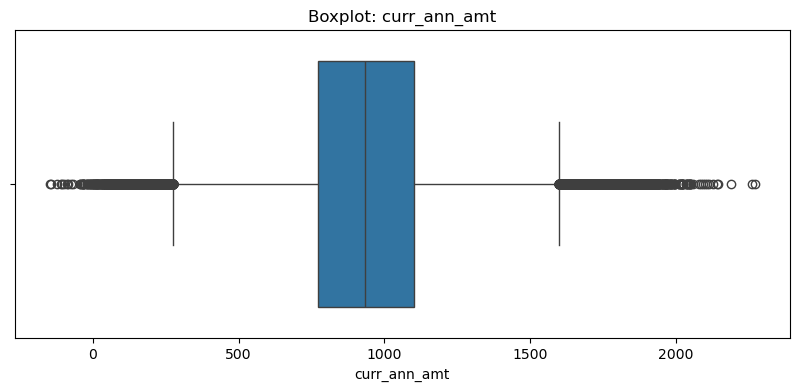

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df['curr_ann_amt'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['curr_ann_amt'])
plt.title('Boxplot: curr_ann_amt')
plt.show()

count   1,041,065.00
mean        3,586.11
std         2,339.73
min            20.00
25%         1,384.00
50%         3,616.00
75%         6,291.00
max         6,291.00
Name: days_tenure, dtype: float64


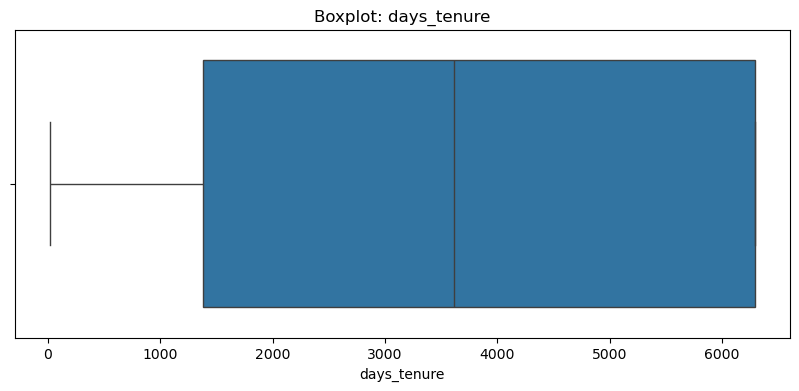

In [35]:
print(df['days_tenure'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['days_tenure'])
plt.title('Boxplot: days_tenure')
plt.show()

count   1,041,065.00
mean           55.75
std            14.55
min            23.00
25%            45.00
50%            55.00
75%            64.00
max           114.00
Name: age_in_years, dtype: float64


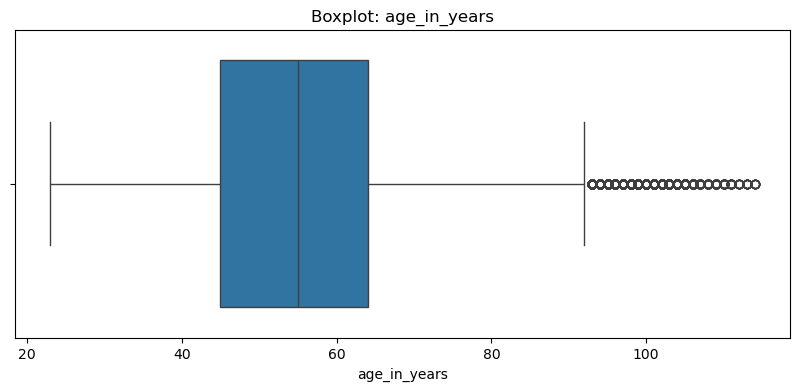

In [36]:
print(df['age_in_years'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['age_in_years'])
plt.title('Boxplot: age_in_years')
plt.show()

count   1,041,065.00
mean       81,771.97
std        54,281.44
min         5,000.00
25%        47,500.00
50%        70,000.00
75%        87,500.00
max       250,000.00
Name: income, dtype: float64


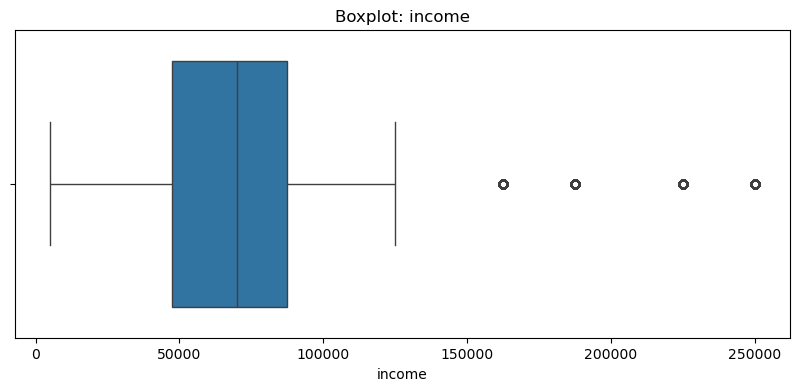

In [37]:
print(df['income'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['income'])
plt.title('Boxplot: income')
plt.show()

count   1,041,065.00
mean            7.48
std             5.13
min             0.00
25%             3.00
50%             6.00
75%            13.00
max            15.00
Name: length_of_residence, dtype: float64


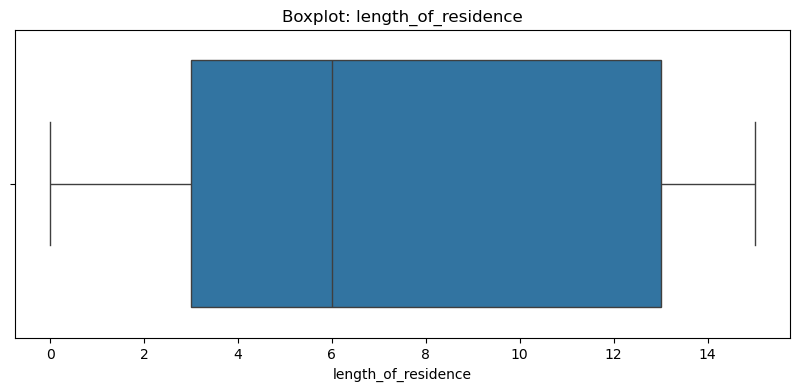

In [38]:
print(df['length_of_residence'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['length_of_residence'])
plt.title('Boxplot: length_of_residence')
plt.show()

count   1,041,065.00
mean      133,368.92
std        88,349.41
min        12,999.50
25%        87,499.50
50%       112,499.50
75%       162,499.50
max     1,000,000.00
Name: home_market_value, dtype: float64


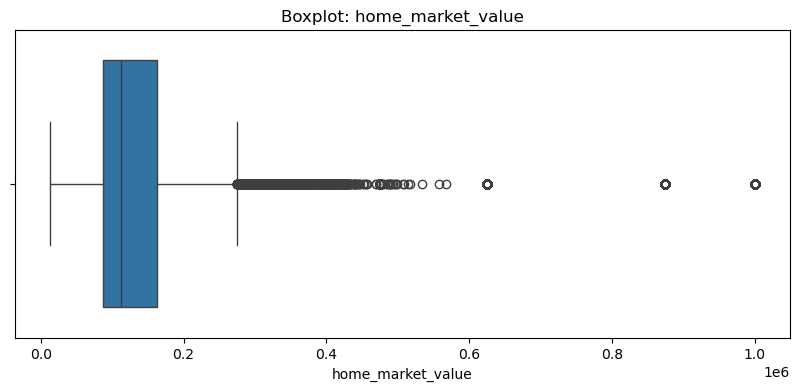

In [39]:
print(df['home_market_value'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['home_market_value'])
plt.title('Boxplot: home_market_value')
plt.show()

Vemos que no hay unos valores fuera de lo común. Pese a detectarse como outliers, podemos entender que son valores alejados de lo normal pero perfectamente posibles.

### Vamos a realizar ahora un analisis exploratorio de algunas variables.

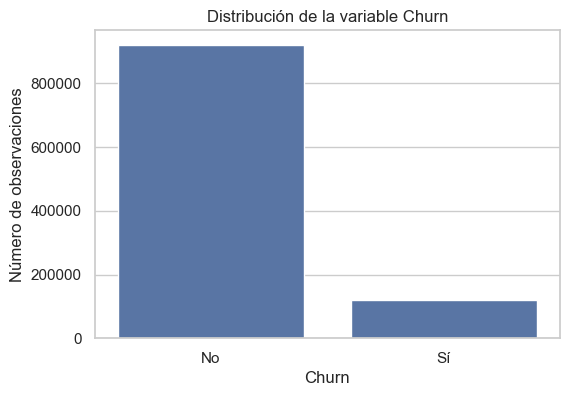

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de la variable Churn')
plt.xlabel('Churn')
plt.ylabel('Número de observaciones')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()


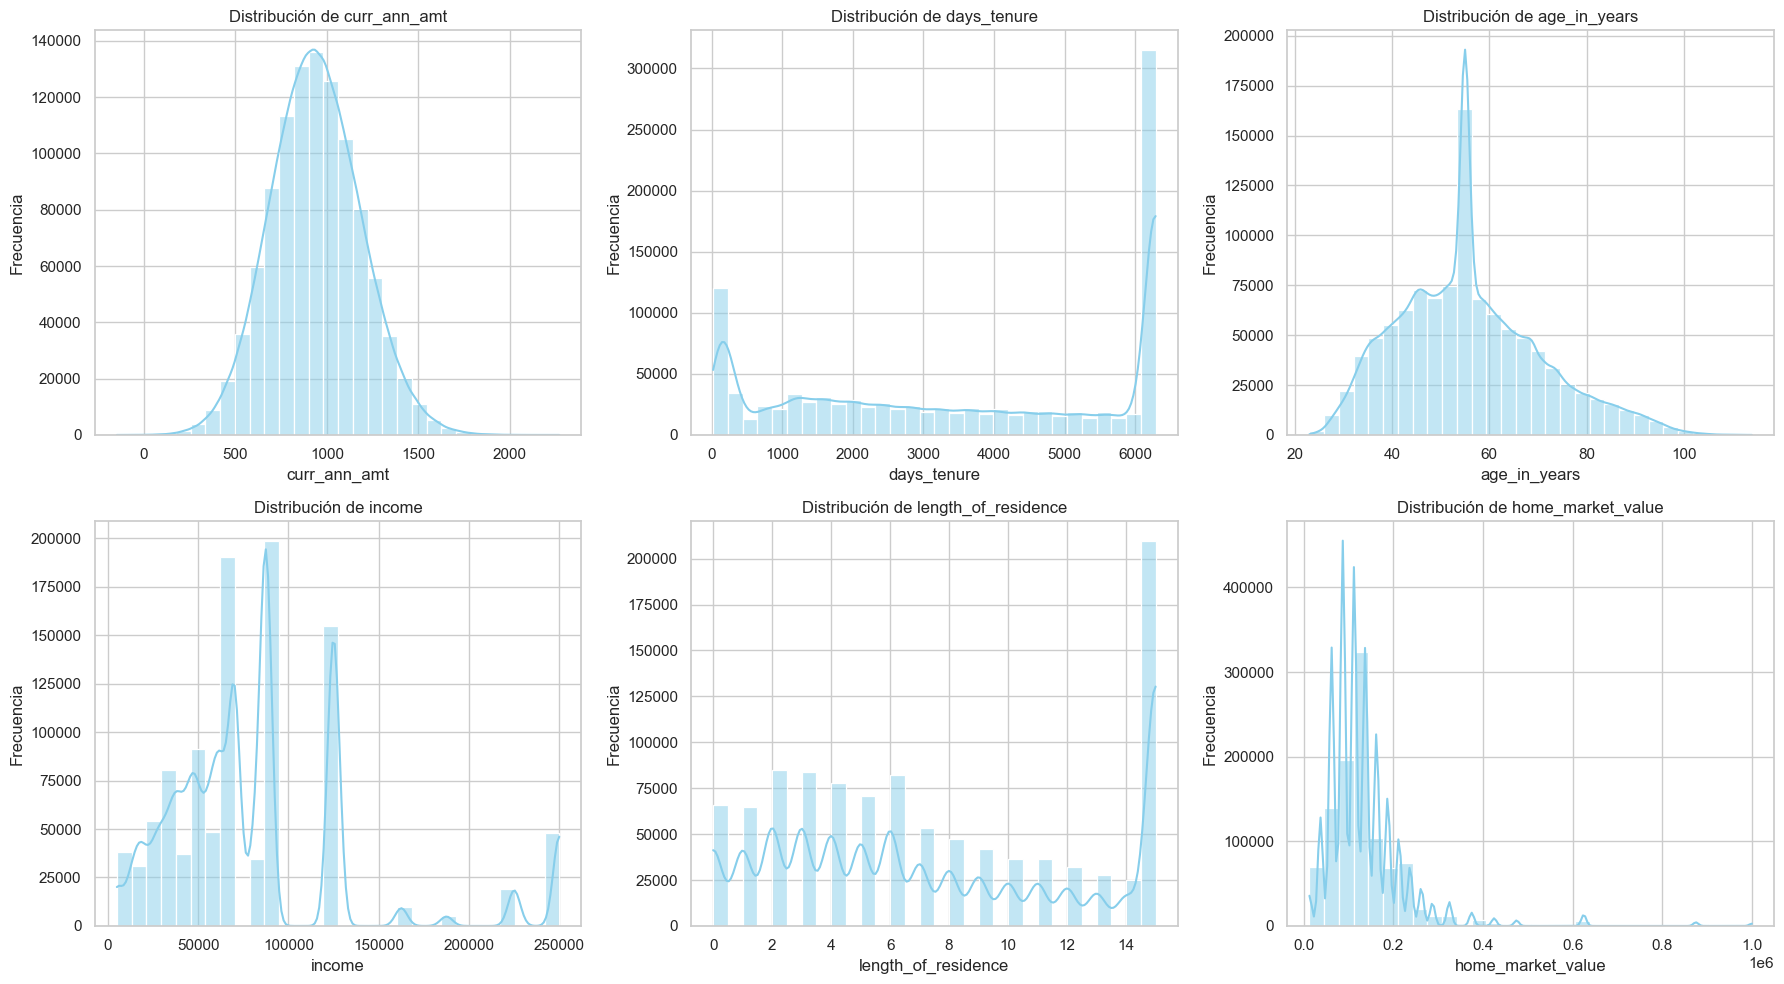

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_continuas = ['curr_ann_amt', 'days_tenure', 'age_in_years', 
                       'income', 'length_of_residence', 'home_market_value']

sns.set(style="whitegrid")

# Crear una figura con subgráficos
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten() 

for i, var in enumerate(variables_continuas):
    sns.histplot(data=df, x=var, kde=True, bins=30, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [42]:
# Consultar los valores más repetidos de age_in_years
valores_mas_repetidos = df['age_in_years'].value_counts().head(10)
print(valores_mas_repetidos)

age_in_years
55    113585
53     25300
52     25129
54     25097
56     24469
45     24466
51     24439
46     24357
47     23550
57     23307
Name: count, dtype: int64


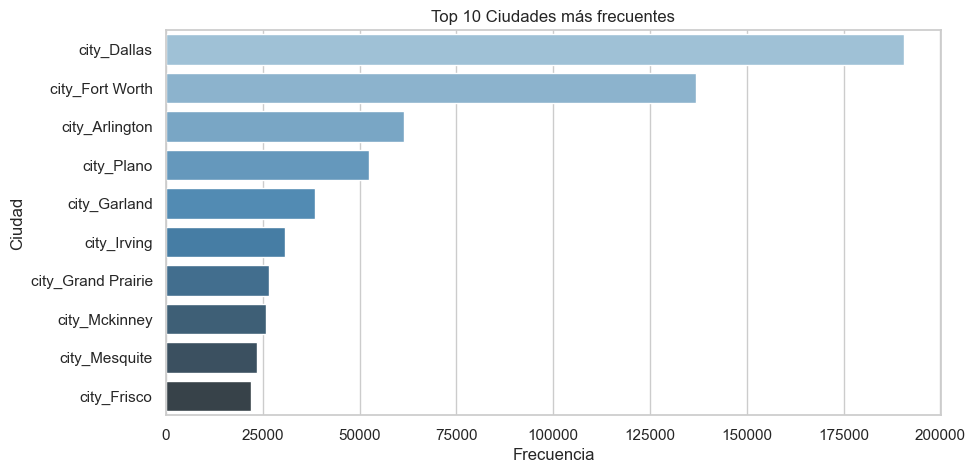

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener columnas que corresponden a las ciudades
city_columns = [col for col in df.columns if col.startswith('city_')]
top_cities = df[city_columns].sum().sort_values(ascending=False).head(10)

top_cities_df = top_cities.reset_index()
top_cities_df.columns = ['city', 'count']

plt.figure(figsize=(10, 5))
sns.barplot(data=top_cities_df, x='count', y='city', hue='city', legend=False, palette='Blues_d')
plt.title("Top 10 Ciudades más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Ciudad")
plt.show()

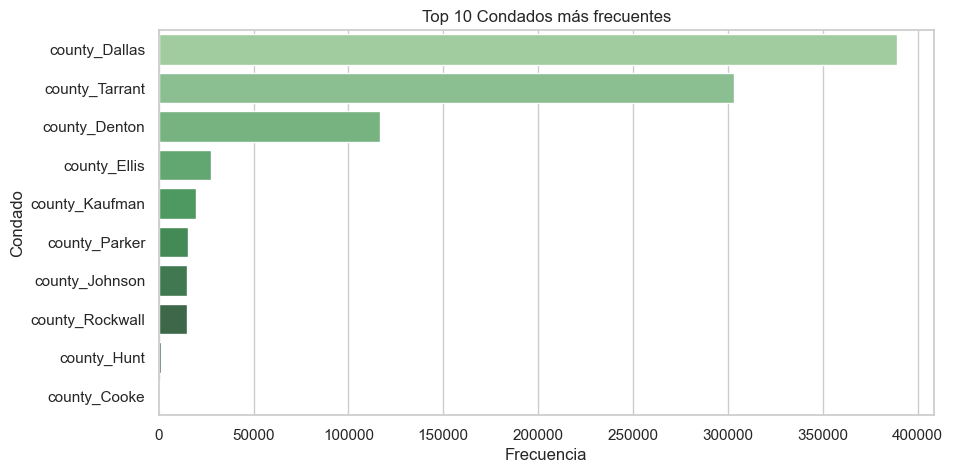

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener columnas que corresponden a los condados
county_columns = [col for col in df.columns if col.startswith('county_')]
top_counties = df[county_columns].sum().sort_values(ascending=False).head(10)

top_counties_df = top_counties.reset_index()
top_counties_df.columns = ['county', 'count']

plt.figure(figsize=(10, 5))
sns.barplot(data=top_counties_df, x='count', y='county', hue='county', legend=False, palette='Greens_d')
plt.title("Top 10 Condados más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Condado")
plt.show()


## Guardamos ahora el dataframe como un nuevo archivo csv.

In [45]:
df.to_csv('df_procesado.csv', index=False)

## CARGA DEL CONJUNTO DE DATOS PREPROCESADO EN UN DF

In [2]:
import pandas as pd
df = pd.read_csv('df_procesado.csv')

## Correlación entre variables.

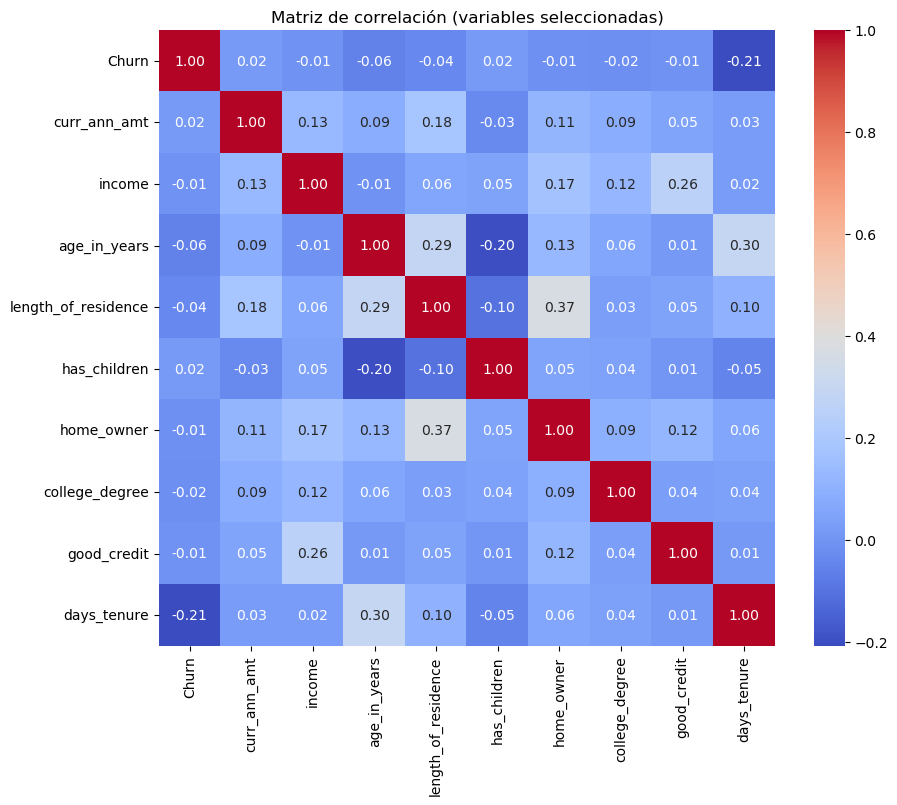

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
variables_clave = ['Churn', 'curr_ann_amt', 'income', 'age_in_years', 
                   'length_of_residence', 'has_children', 'home_owner', 
                   'college_degree', 'good_credit', 'days_tenure']

corr = df[variables_clave].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación (variables seleccionadas)")
plt.show()

In [5]:
import pandas as pd

# Calcular la matriz de correlación
corr_matrix = df.corr(numeric_only=True)

# Crear un DataFrame largo con pares de variables y su correlación
corr_pairs = corr_matrix.unstack()

# Eliminar autocorrelaciones
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Filtrar duplicados
corr_pairs = corr_pairs.drop_duplicates()

# Función para detectar si una variable es de tipo city_ o county_
def is_city_or_county(var):
    return var.startswith("city_") or var.startswith("county_")

# Filtrar correlaciones entre dos variables tipo city_/county_
filtered_pairs = corr_pairs[
    ~(
        corr_pairs.index.get_level_values(0).map(is_city_or_county) &
        corr_pairs.index.get_level_values(1).map(is_city_or_county)
    )
]

# Ordenar por valor absoluto y mostrar las 10 más altas
top_10 = filtered_pairs.reindex(filtered_pairs.abs().sort_values(ascending=False).index).head(10)
print(top_10)

length_of_residence  home_owner             0.367672
income               home_market_value      0.326592
days_tenure          age_in_years           0.295754
age_in_years         length_of_residence    0.287124
marital_status       home_owner             0.265876
income               good_credit            0.257783
                     marital_status         0.245769
days_tenure          Churn                 -0.208674
age_in_years         has_children          -0.203110
length_of_residence  marital_status         0.190370
dtype: float64


In [6]:
# Calcular matriz de correlación
corr = df.corr(numeric_only=True)

# Correlación solo con la variable 'Churn'
churn_corr = corr['Churn'].drop('Churn').sort_values(key=abs, ascending=False)

# Mostrar las 15 variables más correlacionadas con 'Churn'
print(churn_corr.head(15))

days_tenure           -0.208674
age_in_years          -0.055623
length_of_residence   -0.035666
has_children           0.021805
curr_ann_amt           0.017953
college_degree        -0.017461
home_owner            -0.014497
good_credit           -0.007419
income                -0.005424
marital_status        -0.004383
city_Royse City        0.004185
county_Denton          0.003022
city_Prosper           0.002817
city_Flower Mound      0.002721
city_Dallas           -0.002621
Name: Churn, dtype: float64


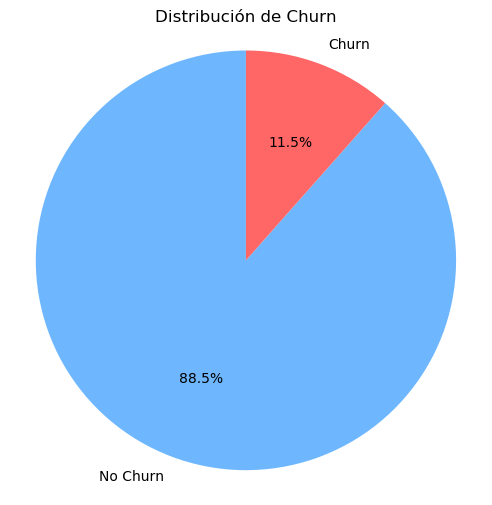

In [7]:
import matplotlib.pyplot as plt

# Contar los valores de Churn
churn_counts = df['Churn'].value_counts()

# Etiquetas
labels = ['No Churn', 'Churn']
colors = ["#6EB7FF", '#ff6666']

# Gráfico
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribución de Churn')
plt.axis('equal')
plt.show()

## DIVIDIMOS EN TRAIN Y TEST

In [3]:
from sklearn.model_selection import train_test_split

# Separar X e y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## ESCALADO CON MIN MAX SCALER

In [4]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['curr_ann_amt', 'days_tenure', 'age_in_years', 'income', 'length_of_residence', 'home_market_value']

scaler = MinMaxScaler()

# Escalamos solo las columnas continuas
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


## SMOTE

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled_SMOTE, y_train_resampled_SMOTE = smote.fit_resample(X_train_scaled, y_train)


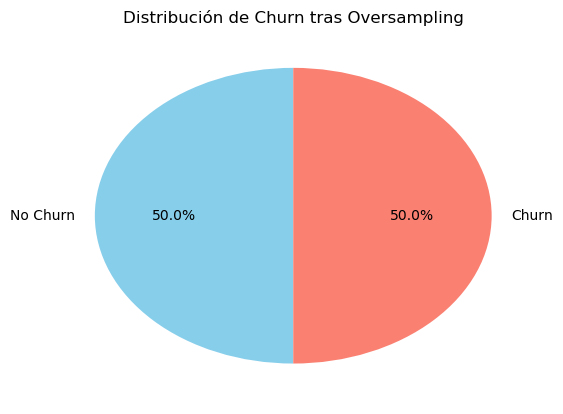

In [11]:
import matplotlib.pyplot as plt

y_train_resampled_SMOTE.value_counts().plot.pie(autopct='%1.1f%%', labels=['No Churn', 'Churn'], startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribución de Churn tras Oversampling')
plt.ylabel('')
plt.show()

In [12]:
print(y_train_resampled_SMOTE.value_counts())

Churn
0    736869
1    736869
Name: count, dtype: int64


In [13]:
print(y_test.value_counts())

Churn
0    184217
1     23996
Name: count, dtype: int64


## MODELO DE REGRESIÓN LOGISTICA

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    184217
           1       0.00      0.00      0.00     23996

    accuracy                           0.88    208213
   macro avg       0.44      0.50      0.47    208213
weighted avg       0.78      0.88      0.83    208213

ROC AUC: 0.6887


c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


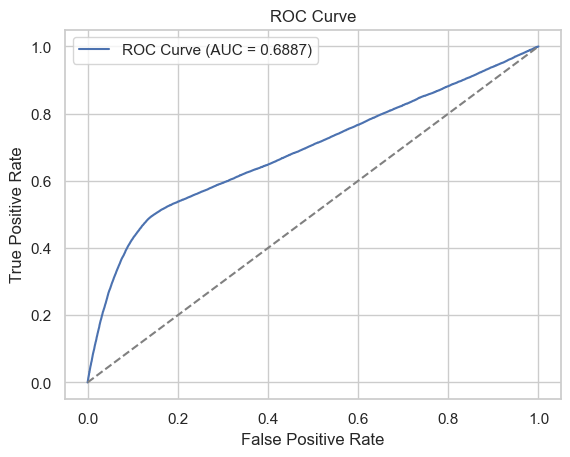

In [56]:
# Sin SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenamiento del modelo
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predicción de clases
y_pred = model.predict(X_test_scaled)

# Predicción de probabilidades
y_proba = model.predict_proba(X_test_scaled)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cálculo del ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC (opcional pero recomendable)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73    184217
           1       0.18      0.65      0.28     23996

    accuracy                           0.61    208213
   macro avg       0.55      0.63      0.50    208213
weighted avg       0.84      0.61      0.68    208213

ROC AUC: 0.6864


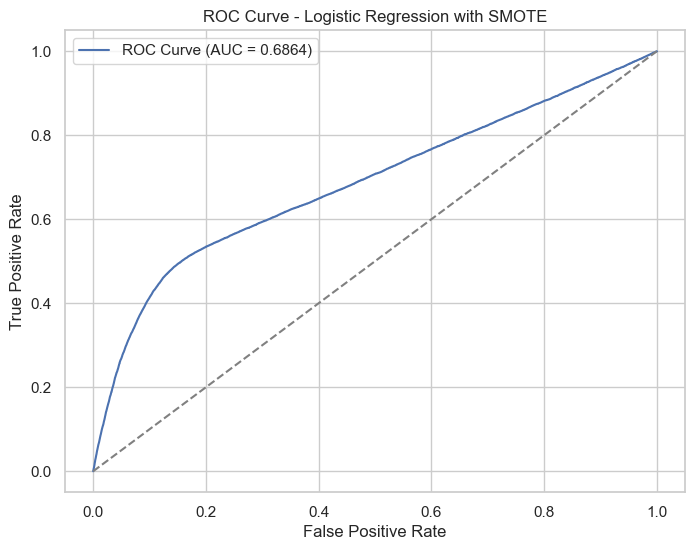

In [57]:
# Con SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenamiento con los datos balanceados por SMOTE
model = LogisticRegression()
model.fit(X_train_resampled_SMOTE, y_train_resampled_SMOTE)

# Predicción de clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC (opcional)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with SMOTE')
plt.legend()
plt.grid(True)
plt.show()


## MODELO Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94    184217
           1       0.50      0.18      0.26     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.58      0.60    208213
weighted avg       0.86      0.88      0.86    208213

ROC AUC: 0.6980


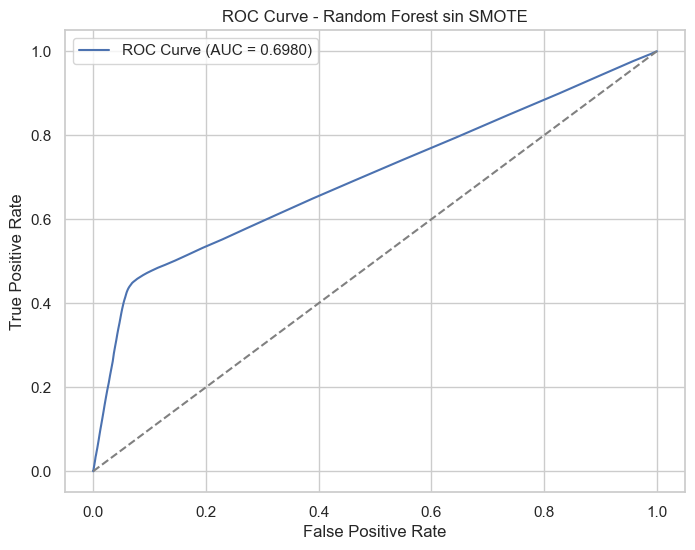

In [58]:
# Sin SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Predecir clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluar resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular y mostrar ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC (opcional)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest sin SMOTE')
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    184217
           1       0.46      0.37      0.41     23996

    accuracy                           0.88    208213
   macro avg       0.69      0.66      0.67    208213
weighted avg       0.87      0.88      0.87    208213

ROC AUC: 0.6962


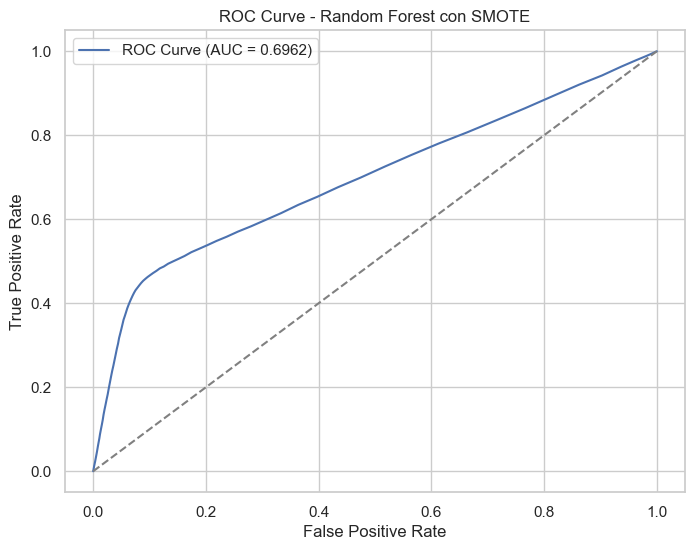

In [59]:
# Con SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo Random Forest con datos balanceados (SMOTE)
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled_SMOTE, y_train_resampled_SMOTE)

# Predecir clases y probabilidades en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluar resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest con SMOTE')
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94    184217
           1       0.50      0.15      0.23     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.57      0.59    208213
weighted avg       0.85      0.88      0.86    208213

ROC AUC: 0.6967


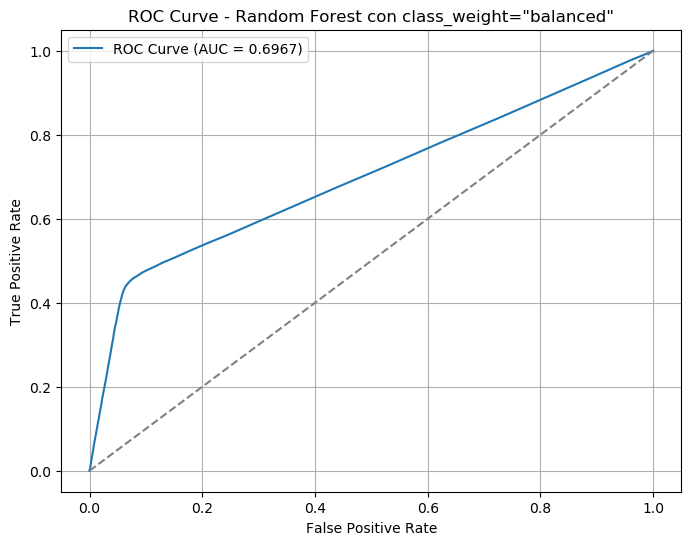

In [ ]:
# Random Forest con Cost-sensitive learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo Random Forest con ajuste de clases por desbalanceo
model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # Cost-sensitive learning
)
model.fit(X_train_scaled, y_train)

# Predecir clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluar resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular y mostrar ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest con class_weight=\"balanced\"')
plt.legend()
plt.grid(True)
plt.show()


## MODELO DE XGBOOST

c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:59] WARNING: D:\bld\xgboost-split_1747336820434\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94    184217
           1       0.50      0.21      0.29     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.59      0.61    208213
weighted avg       0.86      0.88      0.86    208213

ROC AUC: 0.6988


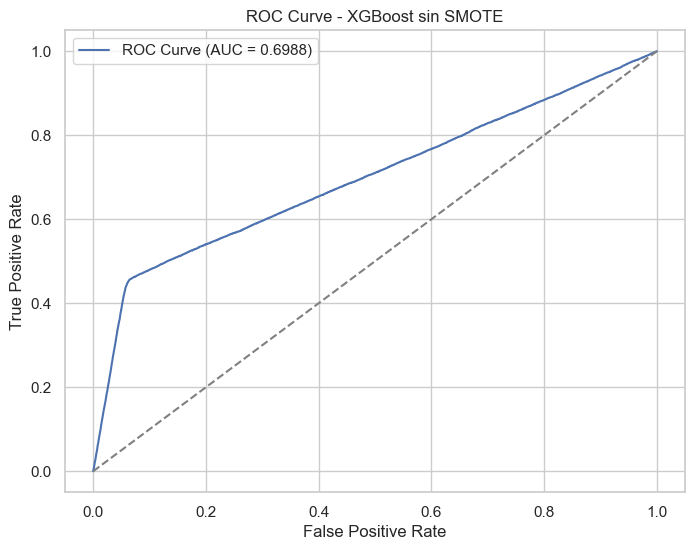

In [60]:
# Sin SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo XGBoost
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predecir clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluar resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost sin SMOTE')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\xgboost\training.py:183: UserWarning: [13:31:12] WARNING: D:\bld\xgboost-split_1747336820434\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93    184217
           1       0.48      0.34      0.40     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.65      0.67    208213
weighted avg       0.87      0.88      0.87    208213

ROC AUC: 0.6964


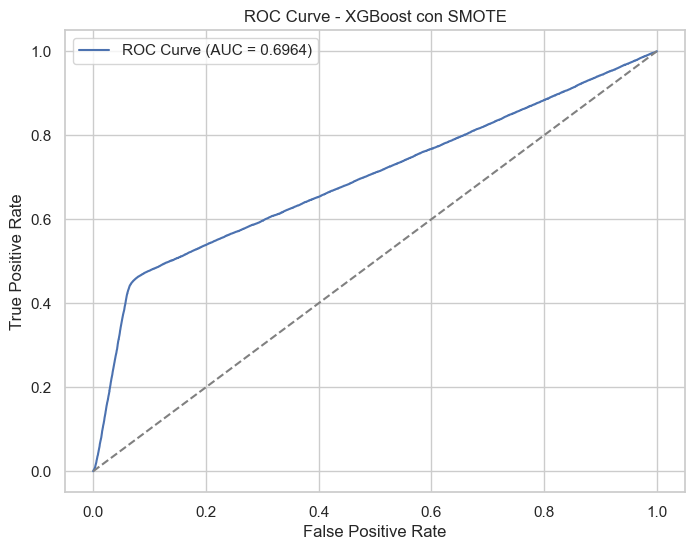

In [61]:
# Con SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo XGBoost con datos balanceados (SMOTE)
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_resampled_SMOTE, y_train_resampled_SMOTE)

# Predecir clases y probabilidades en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluar resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost con SMOTE')
plt.legend()
plt.grid(True)
plt.show()


scale_pos_weight: 7.68


c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [07:40:21] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8729522172006551
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    184217
           1       0.45      0.46      0.46     23996

    accuracy                           0.87    208213
   macro avg       0.69      0.70      0.69    208213
weighted avg       0.87      0.87      0.87    208213

ROC AUC: 0.6978


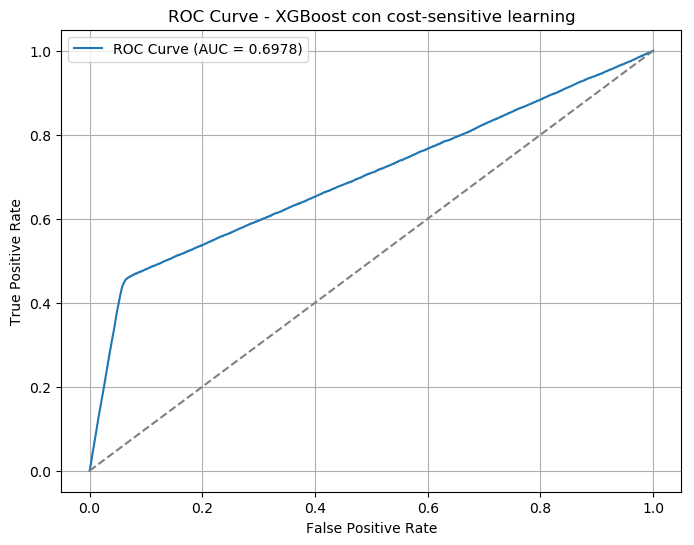

In [ ]:
# (Cost-sensitive learning)
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Calcular el ratio de clases para scale_pos_weight
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Crear y entrenar el modelo XGBoost con cost-sensitive learning
model = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train)

# Predicción de clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluación de métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost con cost-sensitive learning')
plt.legend()
plt.grid(True)
plt.show()


## MODELO LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 95983, number of negative: 736869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 832852, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115246 -> initscore=-2.038239
[LightGBM] [Info] Start training from score -2.038239
Accuracy: 0.8850696162103231
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94    184217
           1       0.50      0.21      0.30     23996

    accuracy                           0.89    208213
   macro avg       0.70      0.59      0.62    208213
weighted avg       0.86      0.89  

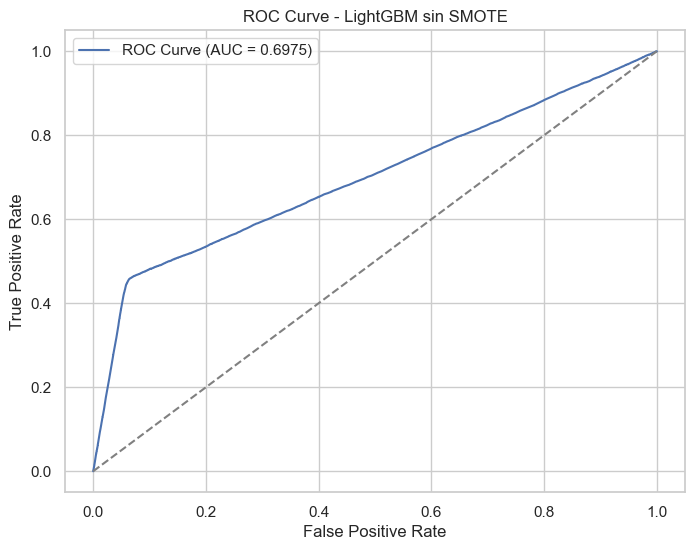

In [62]:
# Sin SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo LightGBM
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Predicción de clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluación de métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM sin SMOTE')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 736869, number of negative: 736869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1473738, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8806894862472564
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    184217
           1       0.48      0.39      0.43     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.67      0.68    208213
weighted avg       0.87      0.88      0.88    208213

ROC AUC: 0.6975


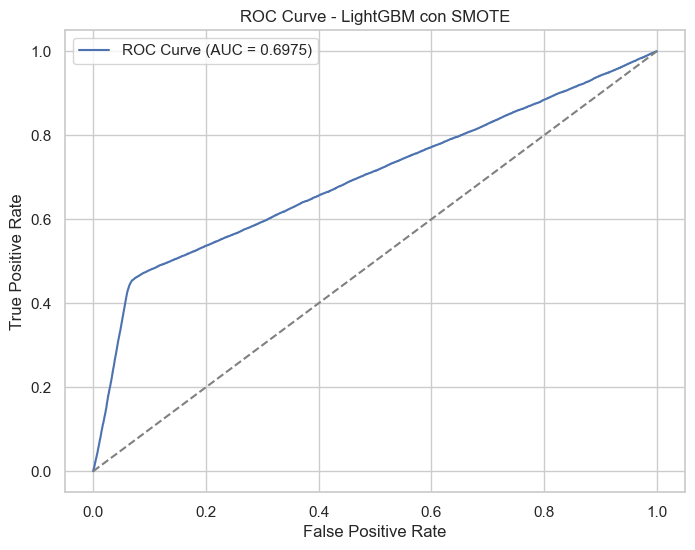

In [56]:
# Con SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo LightGBM con datos balanceados (SMOTE)
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_resampled_SMOTE, y_train_resampled_SMOTE)

# Predicción de clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluación de métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM con SMOTE')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 95983, number of negative: 736869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 832852, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Accuracy: 0.8785858711992046
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    184217
           1       0.47      0.46      0.47     23996

    accuracy                           0.88    208213
   macro avg       0.70      0.70      0.70    208213
weighted avg       0.88      0.88    

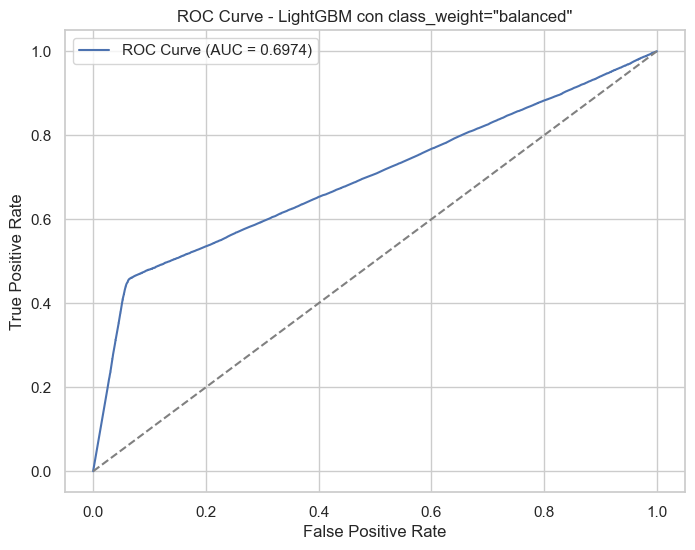

In [57]:
# (Cost-sensitive learning)
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenar modelo LightGBM con class_weight='balanced'
model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predicción de clases y probabilidades
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

# Evaluación de métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM con class_weight="balanced"')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# SHAP PARA EVALUAR LA INTERPRETABILIDAD DEL MODELO

import shap
import numpy as np

# Crear el objeto explicador con el modelo LightGBM
explainer = shap.TreeExplainer(model)

# Calcular los valores SHAP para las predicciones del conjunto de test
shap_values = explainer.shap_values(X_test_scaled)

c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


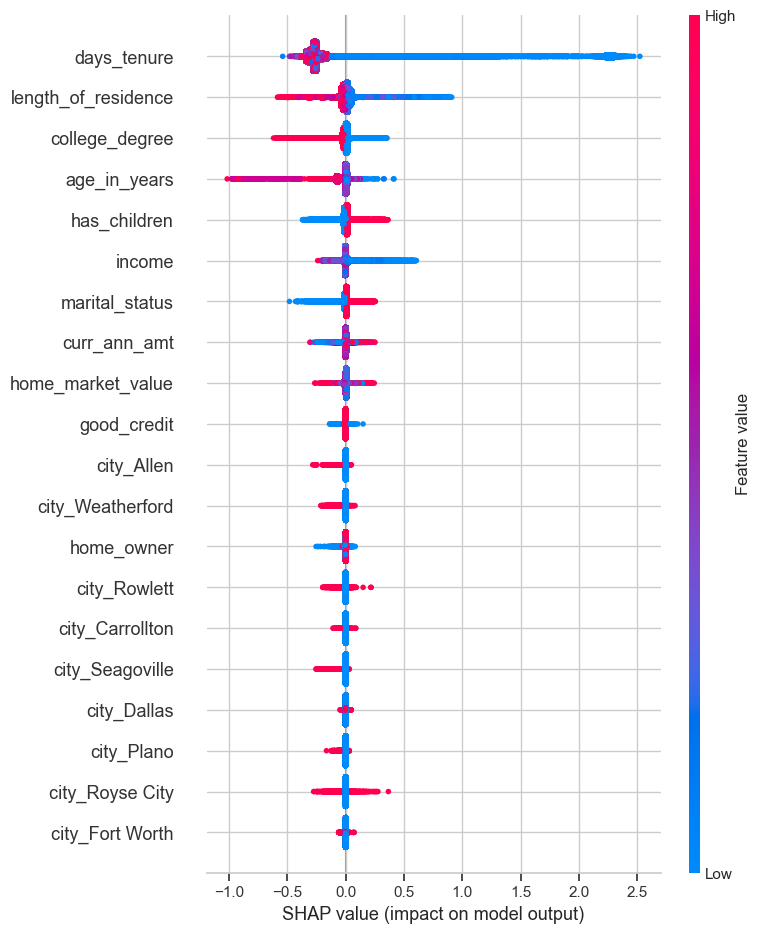

In [59]:
# Gráfico resumen de importancia de variables
shap.summary_plot(shap_values, X_test_scaled)

## MODELO REGRESION LINEAL CON PCA

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73    184217
           1       0.18      0.65      0.28     23996

    accuracy                           0.61    208213
   macro avg       0.55      0.63      0.50    208213
weighted avg       0.84      0.61      0.68    208213

ROC AUC: 0.6880


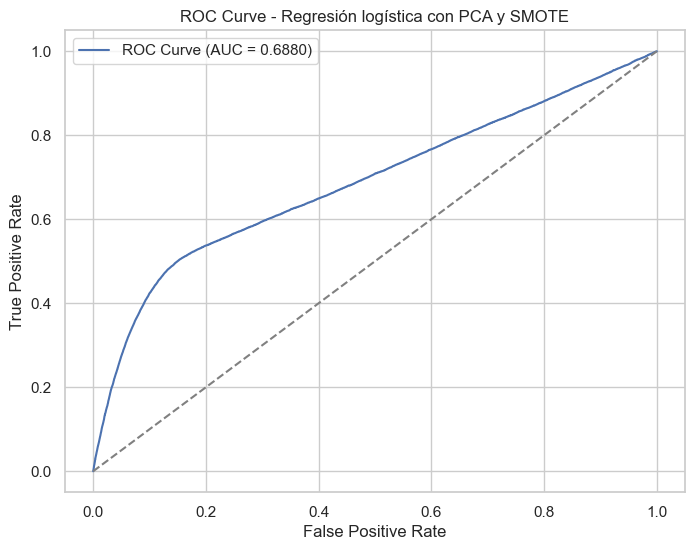

In [65]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled_SMOTE)
X_test_pca = pca.transform(X_test_scaled)

# Entrenar el modelo
model = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced')
model.fit(X_train_pca, y_train_resampled_SMOTE)

# Predicción
y_pred = model.predict(X_test_pca)
y_prob = model.predict_proba(X_test_pca)[:, 1]

# Evaluación
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Regresión logística con PCA y SMOTE')
plt.legend()
plt.grid(True)
plt.show()


## MODELO LIGHTGBM CON PCA

[LightGBM] [Info] Number of positive: 736869, number of negative: 736869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 1473738, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89    184217
           1       0.32      0.50      0.39     23996

    accuracy                           0.82    208213
   macro avg       0.62      0.68      0.64    208213
weighted avg       0.86      0.82      0.84    208213

ROC AUC Score: 0.6946


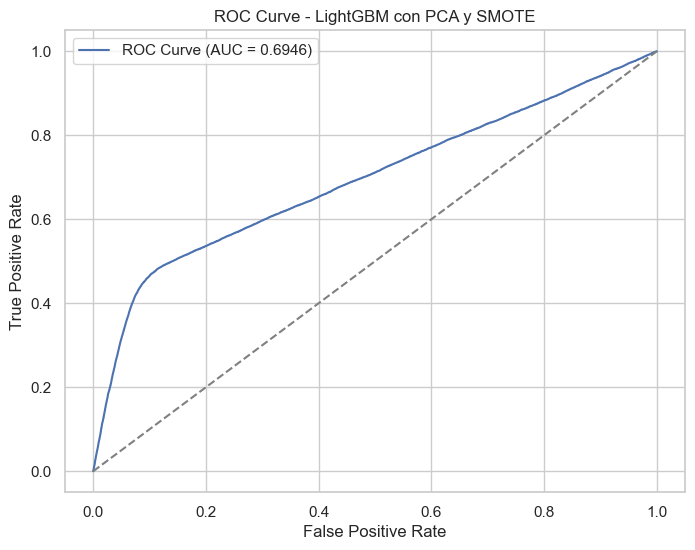

In [66]:
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_resampled_SMOTE)  
X_test_pca = pca.transform(X_test_scaled) 

# Crear y entrenar el modelo LightGBM
model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_pca, y_train_resampled_SMOTE)

# Predicción y evaluación
y_pred = model.predict(X_test_pca)
y_prob = model.predict_proba(X_test_pca)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM con PCA y SMOTE')
plt.legend()
plt.grid(True)
plt.show()



## CONCLUSIONES

En este apartado detallaremos las conclusiones del trabajo a partir de los resultados obtenidos tras la ejecución de cada uno de los modelos.
Reflexionaremos acerca de la consecución de los diferentes objetivos planteados al inicio, así como del seguimiento de la planificación y metodología y de los impactos previstos en el apartado 1.3.
Concluiremos el apartado presentando las posibles líneas de trabajo futuro.

A lo largo de este trabajo hemos desarrollado modelos predictivos basados en algoritmos de machine learning con el objetivo de mantener en una empresa a los clientes con posibilidad de abandono.

Tras la primera fase de preprocesado y análisis de las variables, se han evaluado diferentes modelos predictivos con diferentes configuraciones como oversampling, PCA, o cost sensitive learning.

Los resultados obtenidos en todos los modelos se han evaluado, y LightGBM con aprendizaje sensible al coste es el modelo con mejor rendimiento y eficiencia, con los siguientes datos en cada una de las métricas de evaluación.

Hemos comprobado también, la mejora notable en la métrica de recall en los modelos al utilizar técnica de oversampling como SMOTE.

Para finalizar con una mayor capacidad de interpretabilidad, debido a la baja transparencia de modelos como LightGBM, hemos empleado la herramienta SHAP, permitiendo identificar las variables con mas impacto en las predicciones.
Como hemos comentado en el anterior apartado, los clientes con menor antigüedad y estabilidad residencial tienden a presentar una mayor probabilidad de churn.

La metodología basada en CRISP-DM propuesta al comienzo del trabajo se ha adaptado muy bien a nuestro trabajo, pudiendo cumplir los pasos planificados y logrando que no haya inconvenientes en cuanto a la organización y planificación de las tareas del trabajo.

Los resultados obtenidos son capaces de lograr un impacto significativo en la gestión de la cartera de las aseguradoras, pudiendo aplicar políticas de retención más efectivas y focalizadas en los clientes que se predice que pueden abandonar la empresa.

Además, si nos centramos en los impactos previstos en el apartado 1.4 sobre impactos ético-sociales, de sostenibilidad y de diversidad, podemos concluir que hemos logrado mantener la previsión de bajo impacto medioambiental, así como la responsabilidad ética, y de diversidad, género y derechos humanos, no diferenciando ni beneficiando a clientes en función de su género, raza o etnia.

Este trabajo deja abiertas diferentes líneas sobre las que desarrollar y mejorar.
El principal de ellos es la obtención de variables adicional que logren enriquecer el modelo y mejorar su capacidad predictiva. Aunque las variables actuales ofrecen una base sólida para la predicción del churn, la integración de nuevas fuentes de información, como el historial de interacciones con la compañía, encuestas de satisfacción, patrones de navegación en canales digitales o datos temporales relacionados con la renovación de pólizas, podría aportar señales más representativas del comportamiento del cliente y, en consecuencia, mejorar significativamente el rendimiento del modelo.

Otra de las líneas de desarrollo es la optimización de hiperparámetros para diferentes modelos predictivos que logren mejorar la capacidad de predicción y retención de clientes.

